# Image Caption Generator with CNN & LSTM with Neuclius technique

You saw an image and your brain can easily tell what the image is about, but can a computer tell what the image is representing? Computer vision researchers worked on this a lot and they considered it impossible until now! With the advancement in Deep learning techniques, availability of huge datasets and computer power, we can build models that can generate captions for an image.

This is what we are going to implement in this Python based project where we will use deep learning techniques of Convolutional Neural Networks and a type of Recurrent Neural Network (LSTM) together.

## What is Image Caption Generator?

Image caption generator is a task that involves computer vision and natural language processing concepts to recognize the context of an image and describe them in a natural language like English.

### Image Caption Generator with CNN – About the Python based Project

The objective of our project is to learn the concepts of a CNN and LSTM model and build a working model of Image caption generator by implementing CNN with LSTM.

In this Python project, we will be implementing the caption generator using **CNN (Convolutional Neural Networks)*** and LSTM **(Long short term memory)**. The image features will be extracted from Xception which is a CNN model trained on the imagenet dataset and then we feed the features into the LSTM model which will be responsible for generating the image captions.

# The Dataset of Python based Project

For the image caption generator, we will be using the Flickr_8K dataset. There are also other big datasets like Flickr_30K and MSCOCO dataset but it can take weeks just to train the network so we will be using a small Flickr8k dataset. The advantage of a huge dataset is that we can build better models.

we get dataset from **Kaggle** you can download it from here also : <a href="https://www.kaggle.com/datasets/adityajn105/flickr8k">Kaggle-Flicker8k</a> (Size: 1GB).


#### Let's Begin to code.

# Import Modules 

In [2]:
import os   # handling the files
import pickle # storing numpy features
import numpy as np
from tqdm.notebook import tqdm # how much data is process till now
import os
import pickle
import re
import numpy as np
from tqdm import tqdm
from numpy.random import choice
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input # extract features from image data.
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

**os** - used to handle files using system commands.

**pickle** - used to store numpy features extracted

**numpy** - used to perform a wide variety of mathematical operations on arrays

**tqdm** - progress bar decorator for iterators. Includes a default range iterator printing to stderr.

**VGG16, preprocess_input** - imported modules for feature extraction from the image data

**load_img, img_to_array** - used for loading the image and converting the image to a numpy array

**Tokenizer** - used for loading the text as convert them into a token

**pad_sequences** - used for equal distribution of words in sentences filling the remaining spaces with zeros

**plot_model** - used to visualize the architecture of the model through different images

#### Now we must set the directories to use the data

In [3]:
BASE_DIR = 'd:\\'
WORKING_DIR = 'd:\\Codebook\\Deep_Learning\\image_captioning\\Images'

# Extract Image Features

We have to load and restructure the model

VGG-16 is a convolutional neural network that is 16 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database [1]. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals.

In [4]:
# Load vgg16 Model
model = VGG16()

# restructure model
model = Model(inputs = model.inputs , outputs = model.layers[-2].output)

# Summerize
print(model.summary())

553476096/553467096 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

+ Fully connected layer of the VGG16 model is not needed, just the previous layers to extract feature results.

+ By preference you may include more layers, but for quicker results avoid adding the unnecessary layers.

# extract the image features
Now we extract the image features and load the data for preprocess

In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image ID
    image_id = img_name.split('.')[0]
    # store feature
    features[image_id] = feature
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features1.pkl'), 'wb'))

  0%|          | 0/8091 [00:00<?, ?it/s]

Dictionary 'features' is created and will be loaded with the extracted features of image data

**load_img(img_path, target_size=(224, 224))** - custom dimension to resize the image when loaded to the array

**image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))** - reshaping the image data to preprocess in a RGB type image.

**model.predict(image, verbose=0)** - extraction of features from the image

**img_name.split('.')[0]** - split of the image name from the extension to load only the image name.

In [7]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features1.pkl'), 'wb'))

Extracted features are not stored in the disk, so re-extraction of features can extend running time

Dumps and store your dictionary in a pickle for reloading it to save time

In [8]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features1.pkl'), 'rb') as f:
    features = pickle.load(f)

Load all your stored feature data to your project for quicker runtime 

## Load the Captions Data

Let us store the captions data from the text file

In [9]:
with open(os.path.join(BASE_DIR, 'Codebook', 'Deep_Learning', 'image_captioning', 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

### Now we split and append the captions data with the image

In [10]:
# Create mapping of image to captions
mapping = {}
# Process lines
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert caption list to string
    caption = " ".join(caption)
    # Create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # Store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

+ Dictionary 'mapping' is created with key as image_id and values as the corresponding caption text

+ Same image may have multiple captions, **if image_id not in mapping: mapping[image_id] = []** creates a list for appending captions to the corresponding image

#### Now let us see the no. of images loaded

In [11]:
len(mapping)

8091

# Preprocess Text Data

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Take one caption at a time
            caption = captions[i]
            # Preprocessing steps
            # Convert to lowercase
            caption = caption.lower()
            # Delete digits, special chars, etc., using regular expression
            caption = re.sub('[^A-Za-z]', '', caption)
            # Delete additional spaces
            caption = re.sub('\s+', ' ', caption)
            # Add start and end tags to the caption
            caption = 'sr ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' end'
            captions[i] = caption



Defined to clean and convert the text for quicker process and better results

Let us visualize the text **before** and **after** cleaning

In [13]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
# preprocess the text
clean(mapping)

In [15]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

#### Next we will store the preprocessed captions into a list

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)

40455

No. of unique captions stored

# 10 Captions
Let us see the first ten captions

In [18]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Processing of Text Data
Now we start processing the text data

In [19]:
# Tokenize the text
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

# Get the maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)


In [20]:
vocab_size

8485

No. of unique words

In [21]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

+ Finding the maximum length of the captions, used for reference for the padding sequence.

# Train Test Split

#### After preprocessing the data now we will train, test and split

In [22]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
test

## nucleus_sampling

In [ ]:
def nucleus_sampling(predictions, p, nucleus_threshold):
    sorted_indices = np.argsort(predictions)[::-1]  # Sort the predictions in descending order
    cumulative_probs = np.cumsum(predictions[sorted_indices])
    
    # Find the smallest subset of indices whose cumulative probability mass exceeds the nucleus threshold
    subset_indices = sorted_indices[cumulative_probs <= nucleus_threshold]
    
    if not subset_indices.any():
        # If the subset is empty, return a random index from the original indices
        return np.random.choice(predictions.shape[0])

    # Normalize the probabilities within the subset
    subset_probs = p[subset_indices] / np.sum(p[subset_indices])
    
    # Sample from the subset using normalized probabilities
    sampled_index = choice(subset_indices, p=subset_probs)
    
    return sampled_index

**Now we will define a batch and include the padding sequence**

In [23]:
# Modify your data generator to use nucleus sampling
def data_generator_nucleus(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size, nucleus_threshold):
    while 1:
        X1, X2, y = [], [], []
        n = 0
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = [], [], []
                n = 0

Padding sequence normalizes the size of all captions to the max size filling them with zeros for better results.

# Model Creation

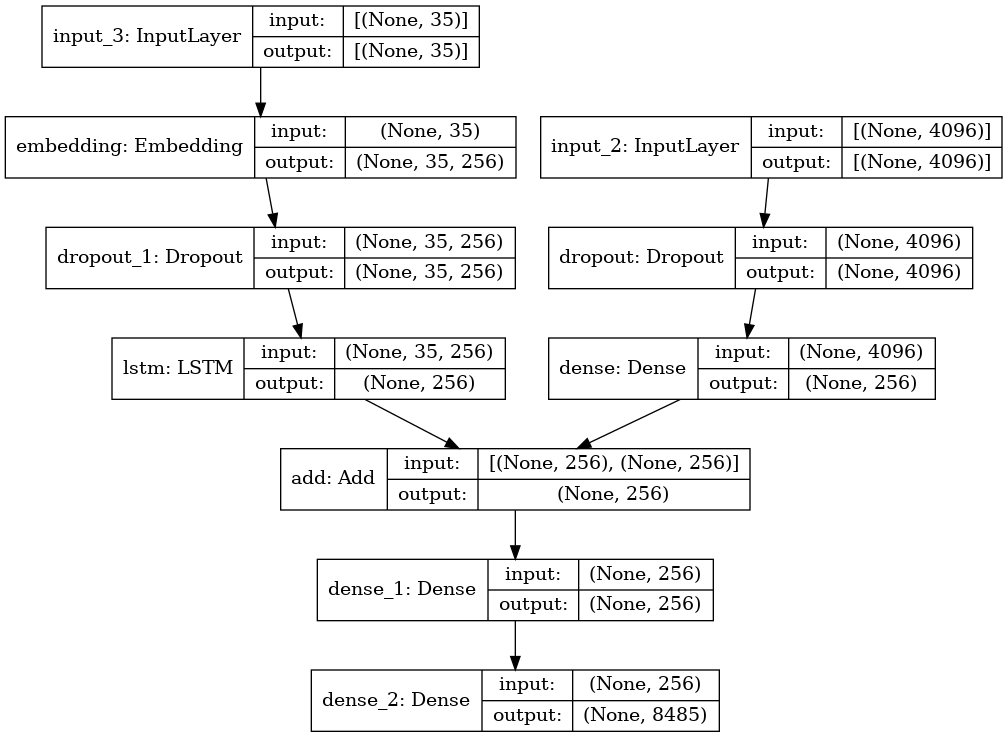

In [24]:
# Image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# Sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')




+ **shape=(4096,)** - output length of the features from the VGG model

+ **Dense** - single dimension linear layer array

+ **Dropout()** - used to add regularization to the data, avoiding over fitting & dropping out a fraction of the data from the layers

+ **model.compile()** - compilation of the model

+ **loss=’sparse_categorical_crossentropy’** - loss function for category outputs

+ **optimizer=’adam’** - automatically adjust the learning rate for the model over the no. of epochs

+ Model plot shows the concatenation of the inputs and outputs into a single layer

+ Feature extraction of image was already done using VGG, no CNN model was needed in this step.

# Train Model
Now let us train the model

In [25]:
# Train the model with Nucleus Sampling
epochs = 20
batch_size = 32
steps = len(train) // batch_size
nucleus_threshold = 0.6  # Set the nucleus threshold

# Modify the model training loop to use nucleus sampling
for i in range(epochs):
    generator = data_generator_nucleus(train, mapping, features, tokenizer, max_length, vocab_size, batch_size, nucleus_threshold)
    for step in range(steps):
        X, y = next(generator)
        
        # Perform nucleus sampling on the predicted probabilities
        predictions = model.predict(X)
        sampled_index = nucleus_sampling(predictions[0], predictions[0], nucleus_threshold)

        # Use the sampled index for training
        y_sampled = np.zeros_like(y)
        y_sampled[:, sampled_index] = y[:, sampled_index]

        model.train_on_batch(X, y_sampled)

    # Save the trained model after each epoch
    model.save("captioning_model_epoch_{}.h5".format(i + 1))

227/227 [==============================] - 42s 184ms/step - loss: 2.1725


+ **steps = len(train) // batch_size** - back propagation and fetch the next data

+ Loss decreases gradually over the iterations

+ Increase the no. of epochs for better results

+ Assign the no. of epochs and batch size accordingly for quicker results


### You can save the model in the working directory for reuse

# Generate Captions for the Image

In [28]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

+ Convert the predicted index from the model into a word

In [29]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

+ Captiongenerator appending all the words for an image

+ The caption starts with 'startseq' and the model continues to predict the caption until the 'endseq' appeared

# Model Validation
Now we validate the data using BLEU Score

In [33]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))


  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.539896
BLEU-2: 0.314331


+ BLEU Score is used to evaluate the predicted text against a reference text, in a list of tokens.

+ The reference text contains all the words appended from the captions data (actual_captions)

+ A BLEU Score more than **0.4 is considered a good result**, for a better score increase the no. of epochs accordingly.

## user predictions

In [34]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, load_model
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

BASE_DIR = 'd:\\'
WORKING_DIR = 'd:\\Codebook\\Deep_Learning\\image_captioning\\Images'

features = 'features.pkl'  # Replace with the actual path
with open(features, 'rb') as f:
    features = pickle.load(f)
    

def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Load the tokenizer from a saved file
tokenizer_path = 'tokenizer1.pkl'  # Replace with the actual path
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)

# Load the mapping of image to captions
with open('captions.txt', 'r') as f:
    next(f)
    captions_doc = f.read()

mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

# Load the trained captioning model
model = load_model('captioning_model.h5')
max_length = 35

# Function to generate a caption for an image
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'st'
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'end':
            break
    return in_text

# Function to generate and display the actual and predicted captions for an image
def generate_caption(image_name):
    img_path = os.path.join(WORKING_DIR, image_name)
    image_id = os.path.splitext(image_name)[0]
    
    # Check if the image_id exists in the mapping dictionary
    if image_id not in mapping:
        print(f"Warning: Image '{image_name}' not found in the dataset. Caption not generated.")
        return
    
    image = Image.open(img_path)
    captions = mapping.get(image_id, [])
    
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)
    plt.show()
#image_captioning\Images\12830823_87d2654e31.jpg
# Example usage
generate_caption("CATPLE_WALLPAPERS_42.jpg")


+ Image caption generator defined

+ First prints the actual captions of the image then prints a predicted caption of the image

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs playing with each other in the snow endseq


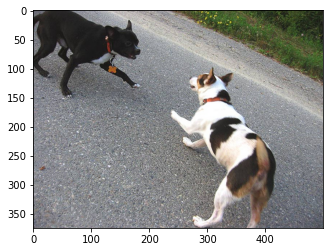

In [31]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq two little children are playing in the snow endseq


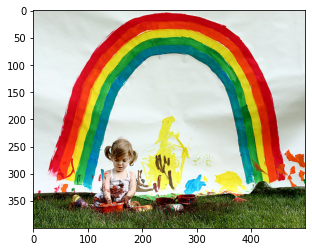

In [35]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq woman crouches near three dogs in field endseq
startseq three dogs are playing on grassy hill with blue sky endseq
startseq three dogs are standing in the grass and person is sitting next to them endseq
startseq three dogs on grassy hill endseq
startseq three dogs stand in grassy field while person kneels nearby endseq
--------------------Predicted--------------------
startseq two dogs playing in field endseq


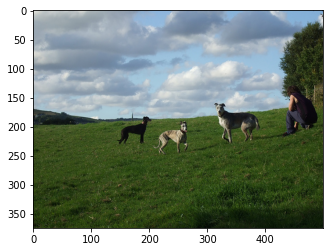

In [38]:
generate_caption("1032122270_ea6f0beedb.jpg")